In [1]:
import numpy as np
import matplotlib.pyplot as plt
from muffin_fullrange import Pool

# Initialization

Muffin Pool, 4 fee tiers (5/12/25/40 bps)

Full-range liquidity only (for simplifying this demo)

Each tier has a liquidity of 40,000,000 DAI + 10,000 ETH.

In [2]:
eth_price = 4000.0
fee_bps = np.array([5, 12, 25, 40], dtype=np.float_)
liquidity = np.sqrt(40_000_000 * 10_000)

def create_pool():
    return Pool(
        sqrt_gamma_arr=np.sqrt(1 - fee_bps/10000),
        liquidity_arr=[liquidity] * len(fee_bps),
        sqrt_p=np.sqrt(eth_price),
    )

In [3]:
def print_swap_result(res):
    print('----- Summary -----')
    print('ETH in:      ', res['amt_in'])
    print('DAI out:     ', -res['amt_out'])
    print('Fee (eth):   ', res['fee_amt'])
    print('Fee % (bps): ', res['fee_bps'])
    print('')
    np.set_printoptions(formatter={'float': lambda x: f'{x:>12.3f}'})
    
    print('----- Breakdown by tier -----')
    print('ETH in (%):  ', res['amts_in'] / res['amt_in'])
    print('ETH in:      ', res['amts_in'])
    print('DAI out:     ', -res['amts_out'])
    print('Fee (eth):   ', res['fee_amts'])
    print('Fee % (bps): ', res['fee_amts'] / res['amts_in'] * 10000)
    print('New price:   ', pool.prices)
    np.set_printoptions(formatter={})

# Example 1: Sell 100 ETH for DAI

In [4]:
ETH = True
DAI = False
pool = create_pool()
res = pool.swap(ETH, 100.)
print_swap_result(res)

----- Summary -----
ETH in:       100.0
DAI out:      398257.3259742678
Fee (eth):    0.16927269584821936
Fee % (bps):  16.927269584821936

----- Breakdown by tier -----
ETH in (%):   [       0.328        0.293        0.228        0.152]
ETH in:       [      32.759       29.263       22.756       15.222]
DAI out:      [  130541.412   116572.783    90592.045    60551.086]
Fee (eth):    [       0.016        0.035        0.057        0.061]
Fee % (bps):  [       5.000       12.000       25.000       40.000]
New price:    [    3973.934     3976.719     3981.902     3987.899]


# Example 2: Randomly selling ETH and DAI

Settings:
- 20 random swaps
- min USD value per swap = $20,000
- min USD value per swap = $200,000


Then, we show the graphs of 
- price movements
- trading volumes
- fees earned per unit of liquidity 


Random seed is cherry-picked to how 12-bps tier earns more fees than the 25-bps.

In [5]:
# parameters
swap_count = 20
min_dai_sold = 20_000  # per swap
max_dai_sold = 200_000  # per swap
np.random.seed(1355)

# create pool
pool = create_pool()

# result data
prices = [pool.prices]
volumes = [np.zeros(len(fee_bps))]
fee_growths = [pool.fee0_growth_arr * pool.price + pool.fee1_growth_arr]

for i in range(swap_count):
    token_in = np.random.choice([ETH, DAI])
    amt_in = (min_dai_sold + np.random.rand() * max_dai_sold)
    amt_in /= pool.price if token_in == ETH else 1
    res = pool.swap(token_in, amt_in)
    
    # record each step's result
    prices.append(pool.prices)
    volumes.append(res['amts_in'] * (pool.price if token_in == ETH else 1))
    fee_growths.append(pool.fee0_growth_arr * pool.price + pool.fee1_growth_arr)

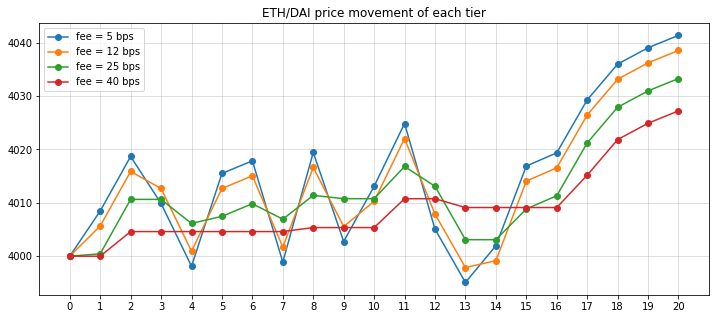

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(prices, 'o-', label=[f'fee = {f:.0f} bps' for f in fee_bps])
plt.title('ETH/DAI price movement of each tier')
plt.xticks(np.arange(0, len(prices)))
plt.legend()
plt.grid(alpha=0.5)

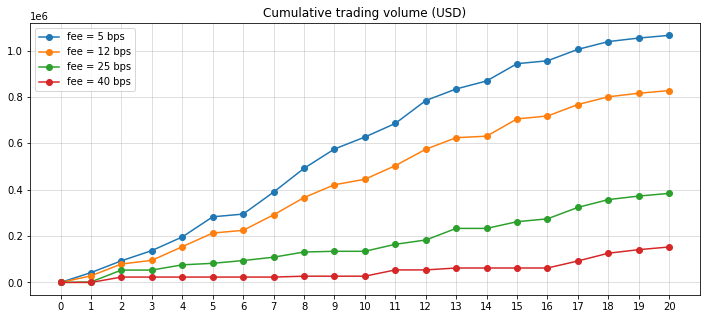

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(volumes, axis=0), 'o-', label=[f'fee = {f:.0f} bps' for f in fee_bps])
plt.title('Cumulative trading volume (USD)')
plt.xticks(np.arange(0, len(fee_growths)))
plt.legend()
plt.grid(alpha=0.5)

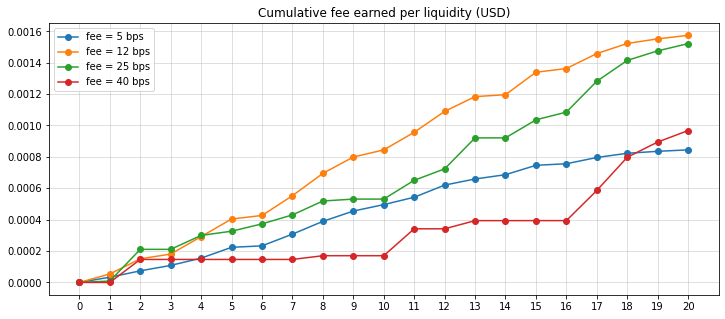

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(fee_growths, 'o-', label=[f'fee = {f:.0f} bps' for f in fee_bps])
plt.title('Cumulative fee earned per liquidity (USD)')
plt.xticks(np.arange(0, len(fee_growths)))
plt.legend()
plt.grid(alpha=0.5)